**Note**

J'ai utilisé la version 1.x de tensorflow et 2.1.6 de keras. Car l'implementation de la couche crf est plus compliquée si l'environement d'éxecution se base sur une version récente de tensorflow / keras ; du fait que le package importé du crf est actuellement incompatible avec la version 2.x.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

%tensorflow_version 1.x

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 1.x selected.


In [ ]:
pip install keras==2.1.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# ELMO embedding + BiLSTM + CRF

## **Why use ELMo Embedding over word2vec and Glove embedding**
Word2vec and Glove word embeddings are context-independent, ie. these models output just one vector (embedding) for each word, irrespective of the context in which the word has been used and then combining all the different senses of the word into one vector representation.

### **Takeaways**

- ELMo embeddings are better than word2vec or Glove embeddings when the context is important for the model.
- Easy to implement ELMo embedding on any text data.
- ELMo embeddings are quite time-consuming. [Compute the embeddings on a GPU and save the model in a pickle file and use the saved weights during deployment or on test data].

The main method of ELMO is training a complete language model, and then using this language
model to deal with the need to train text and generate the corresponding word embedding. When we
use word embedding, the word has a specific context; at this time, word embedding can be fine-tuned
according to the context semantics. The fine-tuned word embedding can better express the specific
meaning of this context and solve the polysemy problem. Therefore, ELMO is essentially the process
of dynamically adjusting word embedding according to the current context.
The structure of the language model is shown below :

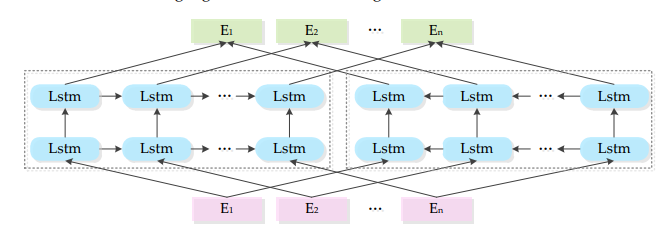


Embedding from Language Model (ELMo), based on the bidirectional LSTM (biLSTM) language
model, is a pretrained deep contextualized word embedding model. Each word token has its own
embedding even though it has the same word type and the embedding of word tokens also depends
on its context.

The ELMo-based BiLSTM-CRF architecture is shown in Figure 3. A list of tokens is the input and
the predicted entity types are the output of the model. The pretrained ELMo, together with a residual
LSTM, are used to learn informative morphological representations from the character sequence of
each token. Then, the word representations will be passed to the BiLSTM layer that includes the
forward LSTM and backward LSTM, and returns a sequence through exploiting both left and right
context information. The outputs of the BiLSTM network are input into the CRF layer. Finally, in the
CRF layer, the NE tags will be decoded and output. 

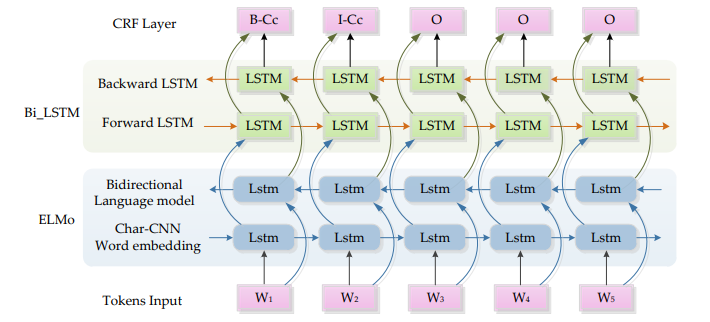

In [ ]:
pip install -U numpy==1.18.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-a4mo_zjy
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-a4mo_zjy


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras_contrib.layers import CRF
plt.style.use("ggplot")

data = pd.read_csv("/content/drive/My Drive/ner_df1.csv", encoding="latin1")
#data = data.drop(['POS'], axis =1)
data = data.fillna(method="ffill")
data.tail(12)

Using TensorFlow backend.


,Unnamed: 0,Sentence #,Word,Tag
6650307,6650307,55142,a,O
6650308,6650308,55142,misspelling,O
6650309,6650309,55142,of,O
6650310,6650310,55142,Sun,O
6650311,6650311,55142,"Oracle,",O
6650312,6650312,55142,zachary:,O
6650313,6650313,55142,refer,O
6650314,6650314,55142,to,O
6650315,6650315,55142,this,O
6650316,6650316,55142,malware,O


In [ ]:
words = set(list(data['Word'].values))
words.add('PADword')
n_words = len(words)
n_words

112266

In [ ]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
n_tags

23

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

None


In [ ]:
sentences = getter.sentences
print(len(sentences))

55142


In [ ]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 18361 words


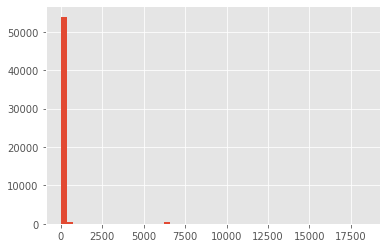

In [ ]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()

In [ ]:
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}


In [ ]:
max_len = 100
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[15]

['The',
 'following',
 'artifacts',
 'can',
 'help',
 'to',
 'determine',
 'whether',
 'a',
 'company',
 'has',
 'been',
 'compromised',
 ':',
 'Ã\x83Â¢Ã\x82Â\x80Ã\x82Â¢',
 'Host',
 'files',
 'and/or',
 'registry',
 'keys',
 'Ã\x83Â¢Ã\x82Â\x80Ã\x82Â¢',
 'Anti-virus',
 'alerts',
 'Ã\x83Â¢Ã\x82Â\x80Ã\x82Â¢',
 'Network',
 'communications',
 '7',
 'White',
 'Paper',
 'Global',
 'Energy',
 'Cyberattacks',
 ':',
 'Night',
 'Dragon',
 'Host',
 'Files',
 'and',
 'Registry',
 'Keys',
 'Utility',
 'Description',
 'Command',
 '&',
 'control',
 'application',
 'zwShell.exe',
 '093640a69c8eafbc60343bf9cd1d3ad3',
 'zwShell.exe',
 '85df6b3e2c1a4c6ce20fc8080e0b53e9',
 'Trojan',
 'dropper',
 'A',
 'packaged',
 'executable',
 'customized',
 'to',
 'each',
 'victim',
 'that',
 'includes',
 'the',
 'DLL',
 'file',
 'and',
 'configuration',
 'settings',
 'for',
 'installing',
 'the',
 'backdoor',
 'on',
 'the',
 'remote',
 'system',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADwor

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

array([ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 11,  6,
        9, 11,  6,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  2,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 11,  9,  9,  9,  4,
       13,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
      dtype=int32)

In [ ]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.2, random_state=2018)


In [ ]:
batch_size = 32
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import backend as K
sess = tf.Session()
K.set_session(sess)

In [ ]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [ ]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [ ]:
from keras.models import Model
from keras.layers import add
from keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

In [ ]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=1000, return_sequences=True,
                       recurrent_dropout=0.4, dropout=0.4))(embedding)
x_rnn = Bidirectional(LSTM(units=1000, return_sequences=True,
                           recurrent_dropout=0.4, dropout=0.4))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="relu"))(x)
# CRF
crf = CRF(n_tags, sparse_target=True)  # CRF layer
output = crf(out)  # output

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model = Model(input_text, output)
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])

/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 100, 1024)    0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 2000)    16200000    lambda_1[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 100, 2000)    24008000    bidirectional_1[0][0]            
__________________________________________________________________________________________________
add_1 (Add

In [ ]:
split_tr = (len(X_tr)//batch_size)*batch_size
split_te = (len(X_te)//batch_size)*batch_size

In [ ]:
X_tr = X_tr[:split_tr]
y_tr = y_tr[:split_tr]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
#y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [ ]:
history = model.fit(np.array(X_tr), y_tr,
                    batch_size=batch_size, epochs=5, verbose=1)

Epoch 1/5



44096/44096 [==============================] - 1271s 29ms/step - loss: 0.1567 - crf_viterbi_accuracy: 0.9553
Epoch 2/5
44096/44096 [==============================] - 1263s 29ms/step - loss: 0.0369 - crf_viterbi_accuracy: 0.9767
Epoch 3/5
44096/44096 [==============================] - 1264s 29ms/step - loss: 0.0075 - crf_viterbi_accuracy: 0.9810
Epoch 4/5
44096/44096 [==============================] - 1265s 29ms/step - loss: -0.0128 - crf_viterbi_accuracy: 0.9824
Epoch 5/5
44096/44096 [==============================] - 1266s 29ms/step - loss: -0.0294 - crf_viterbi_accuracy: 0.9827


In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
X_te = X_te[:split_te]
test_pred = model.predict(np.array(X_te), verbose=1)

11008/11008 [==============================] - 185s 17ms/step


In [ ]:
idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:split_te])


In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 73.7%


In [ ]:
print(classification_report(test_labels, pred_labels))

                        precision    recall  f1-score   support

              ATTACKER       0.78      0.34      0.48      2757
              COMPAIGN       0.98      0.80      0.88       626
                  DATE       0.90      0.70      0.79      1909
   ExploitTargetObject       0.99      0.64      0.77       725
             INDICATOR       0.77      0.47      0.58      1144
           INFORMATION       0.78      0.95      0.86       260
                   LOC       0.69      0.64      0.67      1950
               MALWARE       0.87      0.78      0.82      5557
MALWARECHARACTERISTICS       0.77      0.69      0.73      2536
                 Other       0.74      0.74      0.74   1015666
               PRODUCT       0.62      0.56      0.59      1842
         VULNERABILITY       0.84      0.73      0.78       456

             micro avg       0.74      0.74      0.74   1035428
             macro avg       0.81      0.67      0.72   1035428
          weighted avg       0.74     

In [ ]:
i = 390
p = model.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "PADword":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

Word            Pred : (True)
The            :O     (O)
LUCKK          :O     (O)
cluster        :O     (O)
sub-boards     :O     (O)
of             :O     (O)
of             :O     (O)
four           :B-MALWARE (B-MALWARE)
four           :I-MALWARE (I-MALWARE)
samples        :O     (O)
accelerating:  :O     (O)
the            :O     (O)
set.           :O     (O)
It             :O     (O)
is             :O     (O)
linked         :O     (O)
with           :O     (O)
the            :O     (O)
KOBBX          :O     (O)
array-side     :O     (O)
though         :O     (O)
communication  :O     (O)
(see           :O     (O)
KOBBX          :O     (O)
).             :O     (O)
Cluster:       :O     (O)
LURK0          :O     (O)
The            :O     (O)
LURK0          :O     (O)
/hana/shared/  :O     (O)
consists       :O     (O)
with           :O     (O)
four           :O     (O)
samples        :O     (O)
in             :O     (O)
the            :O     (O)
set.           :O     (O)
This      